In [ ]:
import math
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, BatchNormalization, Conv1DTranspose, AveragePooling1D, UpSampling1D
from tensorflow.keras.regularizers import l2
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
import gc

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Data

In [ ]:
train_dataset = pd.read_csv("/gdrive/My Drive/Colab Notebooks/REHS/drug_target_data/datasets/reduced_train_dataset.csv")
print("Read training data. Now reading testing data")
test_dataset = pd.read_csv("/gdrive/My Drive/Colab Notebooks/REHS/drug_target_data/datasets/reduced_test_dataset.csv")
print("Done reading data")

Read training data. Now reading testing data
Done reading data


In [ ]:
train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')

In [ ]:
train_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047
0,3.231405,-0.045862,-0.022416,2.188148,5.042382,-2.500537,-0.595225,-0.127535,-5.056285,1.806547,0.956628,3.583673,3.130158,6.077588,9.967122,3.852089,6.675878,9.182552,5.927512,5.347445,4.927097,4.430238,-16.500594,-12.697268,-3.731467,11.469455,11.702154,24.620758,-0.772405,2.051831,-0.374071,-1.047108,-1.780478,-0.982952,-2.394727,1.879334,1.236719,2.344369,11.880148,7.9569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.338595,-0.045862,-0.022416,-1.591852,-7.504718,-8.500537,-0.595225,-0.127535,-8.056285,-6.313453,-2.043372,-3.416327,-0.869842,-4.522412,-7.132878,-2.157911,-3.114122,-14.237448,-8.772488,-7.152555,-4.982903,-3.629762,3.899406,-4.397268,29.398533,-27.730545,-28.897846,-47.679242,-2.772405,-3.948169,-0.374071,-0.047108,-1.780478,-6.982952,-0.394727,-2.830666,-0.523281,-8.955631,-15.019852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.301405,-0.045862,-0.022416,3.398148,15.042382,3.499463,-0.595225,-0.127535,10.943715,-0.393453,-2.043372,-2.416327,-0.869842,-1.552412,-2.632878,-1.017911,-1.704122,-3.117448,-2.242488,-1.822555,-1.842903,-1.509762,0.499406,-7.497268,1.578533,-3.130545,-3.897846,-3.479242,-1.772405,-2.948169,-0.374071,-0.047108,-1.780478,3.017048,-0.394727,-1.210666,-0.523281,-3.225631,0.980148,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.378595,-0.045862,-0.022416,-2.451852,-6.367618,-8.500537,1.404775,-0.127535,7.943715,0.106547,-1.043372,-1.416327,-0.869842,-2.112412,-5.892878,-1.570911,-2.556122,-6.717448,-4.922488,-5.552555,-1.932903,-1.619762,-21.100594,-4.997268,-0.651467,-8.230545,-8.797846,-15.479242,1.227595,-1.948169,-0.374071,0.952892,5.219522,-6.982952,0.605273,-2.830666,-0.523281,-8.622631,-11.839852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.471405,-0.045862,-0.022416,0.558148,-3.857618,-2.500537,-0.595225,-0.127535,-8.056285,2.206547,0.956628,-3.416327,0.130158,0.097588,0.677122,-0.507911,-0.634122,1.582552,0.117512,0.417445,-0.902903,-0.619762,12.099406,-11.297268,-4.537467,3.369455,3.002154,6.320758,0.227595,-2.948169,-0.374071,-1.047108,0.219522,1.017048,-0.394727,0.589334,-0.523281,-5.555631,-2.019852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23282,-0.358595,-0.045862,-0.022416,-0.455852,-6.735618,-2.500537,0.404775,-0.227535,-8.056285,-1.273453,0.956628,-1.416327,-0.869842,-2.412412,-4.792878,-1.376911,-2.367122,-5.817448,-3.822488,-3.892555,-2.482903,-2.219762,22.699406,-12.997268,-3.591467,-10.130545,-9.697846,-18.979242,-1.772405,-1.948169,-0.374071,-1.047108,2.219522,-0.982952,0.605273,1.099334,-0.523281,-4.595631,-7.629852,-1.4131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23283,0.76140

Creating validation dataset. Using stratify option to ensure that there are an equal number of each class in both datasets.

In [ ]:
train_feat, val_feat, train_labels, val_labels = train_test_split(train_dataset, train_labels, test_size=0.3, stratify=train_labels, random_state=9032003)

In [ ]:
train_feat.shape

(16300, 3048)

# Machine Learning Model


## Function Definitions


In [ ]:
def calc_metrics(train_labels=None, train_pred=None, test_labels=None, test_pred=None):
  """
  Calculates and prints the Binary Crossentropy, AUC, and accuracy of a model.
  """
  c = keras.metrics.BinaryCrossentropy()
  test_loss = c(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_loss = c(train_labels, train_pred).numpy()
    print(f"Train loss: {train_loss}\nTest Loss: {test_loss}")
  else:
    print(f"Test Loss: {test_loss}")

  a = keras.metrics.AUC(num_thresholds=1000)
  test_auc = a(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_auc = a(train_labels, train_pred).numpy()
    print(f"\nTrain auc: {train_auc}\nTest auc: {test_auc}")
  else:
    print(f"Test auc: {test_auc}")

  acc = keras.metrics.BinaryAccuracy()
  test_acc = acc(test_labels, test_pred).numpy()
  if train_labels is not None:
    train_acc = acc(train_labels, train_pred).numpy()
    print(f"\nTrain acc: {train_acc}\nTest acc: {test_acc}")
  else:
    print(f"Test acc: {test_acc}")

In [ ]:
def check_acc_thresh(pred, labels, max_val=10):
  """
  Calculates the accuracy of the model at different thresholds for the outputs and plots them
  """
  accs = []
  for t in [0.1*j for j in range(1, max_val+1)]:
    acc = keras.metrics.BinaryAccuracy(threshold=t)
    accs.append(acc(labels, pred).numpy())

  plt.title('Accuracy vs Accuracy Threshold')
  plt.ylabel('Accuracy')
  plt.xlabel('Threshold')
  plt.plot([10*j for j in range(1, max_val+1)], accs)
  plt.show()
  print(f"Maximum accuracy: {max(accs)} at a threshold of {10*(accs.index(max(accs))+1)}")

In [ ]:
def create_dataset(feat, labels, batch_size):
  ds = tf.data.Dataset.from_tensor_slices((feat, labels))
  ds = ds.repeat().shuffle(feat.shape[0]).batch(batch_size).prefetch(1)
  return ds

compute_steps_per_epoch = lambda x, b: int(math.ceil(x / b))
reshape_cnn_data = lambda ds: ds.to_numpy().reshape((ds.shape[0], ds.shape[1], 1))

In [ ]:
def roc_plot(feat, labels, model=None, pred=None, title=None, file_path=None, format='png'):
  """
  plots the roc curve of a keras model
  """
  if pred is None:
    pred = model.predict(feat).ravel()
  
  fpr, tpr, thresh = roc_curve(labels, pred)
  auc = roc_auc_score(labels, pred)
  plt.plot(fpr, tpr)
  if title is not None:
    plt.title(title)
  plt.legend(['AUC = %0.2f' % auc], loc='lower right')
  if file_path is not None:
    plt.savefig(file_path, dpi=1200, format=format)
  plt.show()

## Neural Network

Creating datasets with dataset api

In [ ]:
keras.backend.clear_session()

In [ ]:
batch_size=32
train_ds = create_dataset(train_feat, train_labels, batch_size=batch_size)
val_ds = create_dataset(val_feat, val_labels, batch_size=batch_size)

In [ ]:
# building the DNN model
model = keras.Sequential(name='DNN')
model.add(keras.layers.InputLayer(input_shape=(train_feat.shape[1],)))
model.add(Dense(
    4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model.add(Dropout(0.5))
model.add(Dense(
    4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))

# compiling the model
model.compile(
  loss='binary_crossentropy', 
  optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
  metrics=[keras.metrics.AUC(num_thresholds=500), keras.metrics.BinaryAccuracy(threshold=0.5)],
)

#keras.utils.plot_model(model, to_file="dnn_model.png", show_layer_names=False, dpi=1500)

In [ ]:
# building the CNN model
model2 = keras.Sequential(name='CNN')
model2.add(keras.Input(shape=(train_feat.shape[1], 1), name='Input'))
model2.add(Conv1D(16, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Conv1D(32, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Conv1D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(2))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(
    2048, activation='relu', kernel_regularizer=keras.regularizers.l2(l2=0.01)
))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid', name='output'))

# compiling the model
model2.compile(
  loss='binary_crossentropy', 
  optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
  metrics=[keras.metrics.AUC(num_thresholds=500), keras.metrics.BinaryAccuracy(threshold=0.5)]
)

keras.utils.plot_model(model2, to_file="cnn_model.jpg", show_layer_names=False, dpi=1500)

In [ ]:
# stopping the training early if the validation loss does not increase for over 3 epochs
callback = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            # tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=compute_steps_per_epoch(train_feat.shape[0], batch_size),
    epochs=200,
    validation_data=val_ds,
    validation_steps=compute_steps_per_epoch(val_feat.shape[0], batch_size),
    callbacks=[callback],
)

Epoch 1/200
510/510 [==============================] - 10s 18ms/step - loss: 77.3165 - auc_1: 0.5521 - binary_accuracy: 0.5406 - val_loss: 70.8958 - val_auc_1: 0.7640 - val_binary_accuracy: 0.6898
Epoch 2/200
510/510 [==============================] - 9s 17ms/step - loss: 70.4793 - auc_1: 0.6463 - binary_accuracy: 0.6087 - val_loss: 65.4010 - val_auc_1: 0.8120 - val_binary_accuracy: 0.7451
Epoch 3/200
510/510 [==============================] - 9s 17ms/step - loss: 65.1292 - auc_1: 0.6910 - binary_accuracy: 0.6497 - val_loss: 60.9592 - val_auc_1: 0.8203 - val_binary_accuracy: 0.7543
Epoch 4/200
510/510 [==============================] - 9s 17ms/step - loss: 60.5544 - auc_1: 0.7198 - binary_accuracy: 0.6694 - val_loss: 56.8956 - val_auc_1: 0.8366 - val_binary_accuracy: 0.7711
Epoch 5/200
510/510 [==============================] - 9s 17ms/step - loss: 56.7062 - auc_1: 0.7213 - binary_accuracy: 0.6706 - val_loss: 53.4886 - val_auc_1: 0.8270 - val_binary_accuracy: 0.7660
Epoch 6/200
510/510

In [ ]:
# new training
history = model.fit(
    train_ds,
    steps_per_epoch=compute_steps_per_epoch(train_feat.shape[0], batch_size),
    epochs=200,
    validation_data=val_ds,
    validation_steps=compute_steps_per_epoch(val_feat.shape[0], batch_size),
    callbacks=[callback],
)

Epoch 1/200
510/510 [==============================] - 12s 17ms/step - loss: 75.3862 - auc: 0.5830 - binary_accuracy: 0.5651 - val_loss: 71.1507 - val_auc: 0.7532 - val_binary_accuracy: 0.6480
Epoch 2/200
510/510 [==============================] - 8s 16ms/step - loss: 69.1140 - auc: 0.6569 - binary_accuracy: 0.6225 - val_loss: 65.6900 - val_auc: 0.7965 - val_binary_accuracy: 0.6719
Epoch 3/200
510/510 [==============================] - 8s 16ms/step - loss: 63.9144 - auc: 0.6935 - binary_accuracy: 0.6502 - val_loss: 61.1294 - val_auc: 0.8273 - val_binary_accuracy: 0.6832
Epoch 4/200
510/510 [==============================] - 8s 16ms/step - loss: 59.5460 - auc: 0.7185 - binary_accuracy: 0.6699 - val_loss: 57.1399 - val_auc: 0.8182 - val_binary_accuracy: 0.6915
Epoch 5/200
510/510 [==============================] - 8s 17ms/step - loss: 55.7641 - auc: 0.7317 - binary_accuracy: 0.6805 - val_loss: 53.5655 - val_auc: 0.8201 - val_binary_accuracy: 0.7404
Epoch 6/200
510/510 [==================

In [ ]:
# reshaping data to work with convolutional network
conv_train_ds = create_dataset(
    reshape_cnn_data(train_feat), 
    train_labels,
    batch_size)
conv_val_ds = create_dataset(
    reshape_cnn_data(val_feat), 
    val_labels,
    batch_size)

In [ ]:
history = model2.fit(
    conv_train_ds,
    steps_per_epoch=compute_steps_per_epoch(train_feat.shape[0], batch_size),
    epochs=200,
    validation_data=conv_val_ds,
    validation_steps=compute_steps_per_epoch(val_feat.shape[0], batch_size),
    callbacks=[callback],
)

Epoch 1/200
510/510 [==============================] - 19s 34ms/step - loss: 37.7536 - auc_3: 0.5821 - binary_accuracy: 0.5640 - val_loss: 32.2012 - val_auc_3: 0.8098 - val_binary_accuracy: 0.7305
Epoch 2/200
510/510 [==============================] - 17s 34ms/step - loss: 30.9708 - auc_3: 0.7206 - binary_accuracy: 0.6682 - val_loss: 26.8825 - val_auc_3: 0.8440 - val_binary_accuracy: 0.7711
Epoch 3/200
510/510 [==============================] - 17s 34ms/step - loss: 25.9270 - auc_3: 0.7727 - binary_accuracy: 0.7103 - val_loss: 22.7959 - val_auc_3: 0.8603 - val_binary_accuracy: 0.7354
Epoch 4/200
510/510 [==============================] - 17s 34ms/step - loss: 21.9780 - auc_3: 0.7966 - binary_accuracy: 0.7308 - val_loss: 19.4612 - val_auc_3: 0.8704 - val_binary_accuracy: 0.7868
Epoch 5/200
510/510 [==============================] - 17s 34ms/step - loss: 18.8317 - auc_3: 0.8173 - binary_accuracy: 0.7498 - val_loss: 16.8308 - val_auc_3: 0.8701 - val_binary_accuracy: 0.7460
Epoch 6/200
510

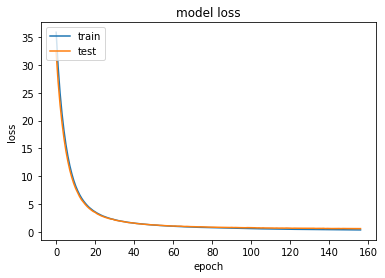

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

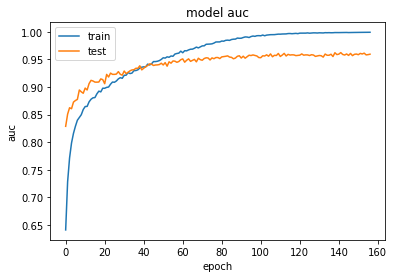

In [ ]:
# summarize history for auc
plt.plot(history.history['auc_29'])
plt.plot(history.history['val_auc_29'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

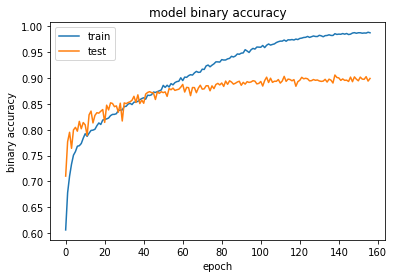

In [ ]:
# summarize history for bin acc
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model 1 metrics (DNN)
metrics = model.evaluate(val_feat, val_labels)

print(f"Validation Loss: {metrics[0]}")
print(f"Validation AUC: {metrics[1]}")
print(f"Validation Binary Acc: {metrics[2]}")

219/219 [==============================] - 1s 6ms/step - loss: 0.6016 - auc_27: 0.9301 - binary_accuracy: 0.8559
Test Loss: 0.6015745401382446
Test AUC: 0.9301238656044006
Test Binary Acc: 0.8558751940727234


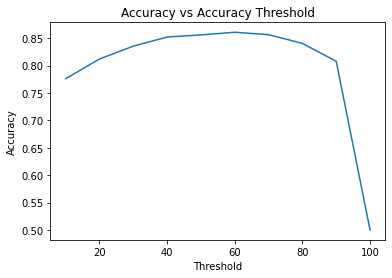

Maximum accuracy: 0.860741376876831 at a threshold of 60


In [ ]:
check_acc_thresh(model.predict(val_feat), val_labels)

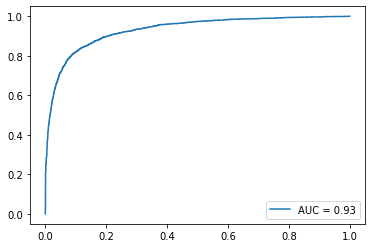

In [ ]:
roc_plot(val_feat, val_labels, model=model)

In [ ]:
# model 2 metrics (CNN)
metrics2 = model2.evaluate(reshape_cnn_data(val_feat), val_labels)

print(f"Validation Loss: {metrics2[0]}")
print(f"Validation AUC: {metrics2[1]}")
print(f"Validation Binary Acc: {metrics2[2]}")

219/219 [==============================] - 3s 12ms/step - loss: 0.3901 - auc_29: 0.9913 - binary_accuracy: 0.9685
Test Loss: 0.39011144638061523
Test AUC: 0.9912758469581604
Test Binary Acc: 0.9685129523277283


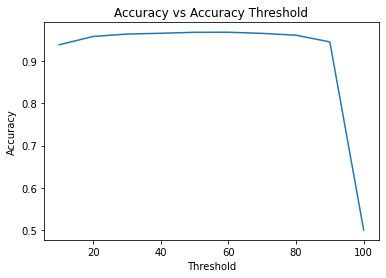

Maximum accuracy: 0.968656063079834 at a threshold of 60


In [ ]:
check_acc_thresh(model2.predict(reshape_cnn_data(val_feat), val_labels)

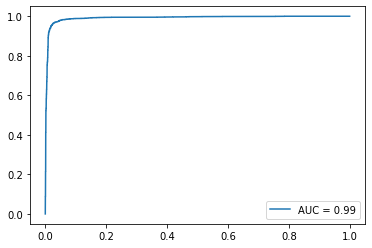

In [ ]:
roc_plot(val_feat.to_numpy().reshape((val_feat.shape[0], val_feat.shape[1], 1)), val_labels, model=model2)

In [ ]:
model.save('/gdrive/My Drive/Colab Notebooks/REHS/models/modelDNN')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/REHS/models/modelDNN/assets


In [ ]:
model2.save('/gdrive/My Drive/Colab Notebooks/REHS/models/model2CNN')

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/REHS/models/model2CNN/assets


In [ ]:
# testing the ensemble of models 1 and 2
predict1 = model.predict(val_feat, use_multiprocessing=True)
predict2 = model2.predict(reshape_cnn_data(val_feat), use_multiprocessing=True)
model_avg = np.mean([predict1, predict2], axis=0).T[0]

calc_metrics(test_labels=val_labels, test_pred=model_avg)

Test Loss: 0.16884073615074158
Test auc: 0.9855970740318298
Test acc: 0.9470444917678833


In [ ]:
# testing the ensemble of model 2 and RandomForest
predict1 = forest.predict_proba(val_feat)[:, 1].reshape(val_feat.shape[0], 1)
predict2 = model2.predict(reshape_cnn_data(val_feat), use_multiprocessing=True)
avg = np.mean([predict1, predict2], axis=0).T[0]

calc_metrics(test_labels=val_labels, test_pred=avg)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Test Loss: 0.17496594786643982
Test auc: 0.9897174835205078
Test acc: 0.9645054936408997


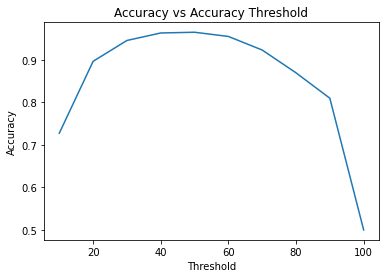

Maximum accuracy: 0.9645054936408997 at a threshold of 50


In [ ]:
check_acc_thresh(avg, val_labels)

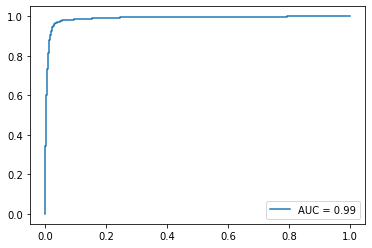

In [ ]:
roc_plot(val_feat, val_labels, pred=avg)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                n_jobs=-1,
                                verbose=1)

In [ ]:
forest.fit(train_feat, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Train loss: 0.1988517791032791
Test Loss: 0.30685582756996155

Train auc: 0.9936942458152771
Test auc: 0.9546312689781189

Train acc: 0.9444376230239868
Test acc: 0.8889365792274475


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


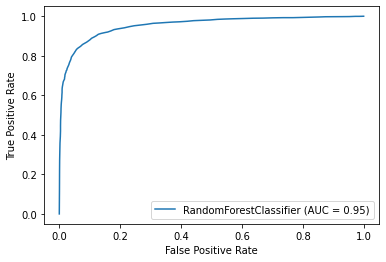

In [ ]:
# calculating metrics
train_forest_pred = forest.predict_proba(train_feat)[:, 1]
val_forest_pred = forest.predict_proba(val_feat)[:, 1]

calc_metrics(train_labels, train_forest_pred, val_labels, val_forest_pred)
# the validation roc plot
plot_roc_curve(forest, val_feat, val_labels)

In [ ]:
dump(forest, '/gdrive/My Drive/Colab Notebooks/REHS/models/random_forest.joblib')

['/gdrive/My Drive/Colab Notebooks/REHS/models/random_forest.joblib']

In [ ]:
forest = load('/gdrive/My Drive/Colab Notebooks/REHS/models/random_forest.joblib')

## SVM

In [ ]:
svm_train_labels = train_labels.replace(0, -1)
svm_test_labels = test_labels.replace(0, -1)

### Linear Kernel

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
linsvm = LinearSVC(penalty='l2',
                  C=0.01)

In [ ]:
linsvm.fit(train_feat, svm_train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
train_pred_lin = linsvm.predict(train_feat)
test_pred_lin = linsvm.predict(test_feat)

In [ ]:
# ignore the loss metric
calc_metrics(train_labels, pd.Series(train_pred_lin).replace(-1, 0), test_labels, pd.Series(test_pred_lin).replace(-1, 0))

Train loss: 3.5974059104919434
Test Loss: 4.375077724456787

Train auc: 0.7679502964019775
Test auc: 0.7159945368766785

Train acc: 0.7660151720046997
Test acc: 0.7153986096382141


In [ ]:
dump(linsvm, '/gdrive/My Drive/Colab Notebooks/REHS/models/linear_svm.joblib')

['/gdrive/My Drive/Colab Notebooks/REHS/models/linear_svm.joblib']

### Radial Kernel

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC(C=1,
          kernel='rbf',
          max_iter=-1,
          gamma='auto')

In [ ]:
svm.fit(train_feat, svm_train_labels)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
train_pred = svm.predict(train_feat)
test_pred = svm.predict(test_feat)

In [ ]:
# ignore loss metric
calc_metrics(train_labels, pd.Series(train_pred).replace(-1, 0), test_labels, pd.Series(test_pred).replace(-1, 0))

Train loss: 0.933665931224823
Test Loss: 2.2126595973968506

Train auc: 0.9392232298851013
Test auc: 0.9008907079696655

Train acc: 0.939301609992981
Test acc: 0.8563748598098755


In [ ]:
dump(svm, '/gdrive/My Drive/Colab Notebooks/REHS/models/radial_svm.joblib')

['/gdrive/My Drive/Colab Notebooks/REHS/models/radial_svm.joblib']

### Quadratic Kernel

In [ ]:
quadsvm = SVC(C=1,
          kernel='poly',
          degree=2,
          max_iter=-1)

In [ ]:
quadsvm.fit(train_feat, svm_train_labels)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
train_pred_quad = quadsvm.predict(train_feat)
test_pred_quad = quadsvm.predict(test_feat)

In [ ]:
# ignore loss metric
calc_metrics(train_labels, pd.Series(train_pred_quad).replace(-1, 0), test_labels, pd.Series(test_pred_quad).replace(-1, 0))

Train loss: 1.0915709733963013
Test Loss: 3.2299818992614746

Train auc: 0.9306480884552002
Test auc: 0.8661063313484192

Train acc: 0.929096519947052
Test acc: 0.79048091173172


Did not perform well.

# Testing on Test Data

The best model was the ensemble of the CNN model (model2) and the RandomForestClassifier. It had the same accuracy and AUC as the CNN but with a much lower loss. Testing that model on the test data to see how it performs on an unseen dataset.

Also testing the two models individually to compare them.

In [ ]:
model = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/REHS/models/modelDNN')
model2 = keras.models.load_model('/gdrive/My Drive/Colab Notebooks/REHS/models/model2CNN')
forest = load('/gdrive/My Drive/Colab Notebooks/REHS/models/random_forest.joblib')

In [ ]:
from statistics import harmonic_mean

In [ ]:
def precision_recall(model, test_features, test_labels, model_type='', save_file=None):
  """
  Prints precision and recall scores of a model and creates precision-recall curve
  """
  test_pred = model.predict(test_features)

  print('Ran predictions. See metrics below:\n\n')

  # getting values to plot for precision-recall curve (does not use rounded outputs)
  precisions, recalls, thresholds = precision_recall_curve(test_labels, test_pred)
  c = keras.metrics.AUC(curve='pr')
  prAUC = c(test_labels, test_pred).numpy()

  # getting numerical values for metrics at the threshold
  c = keras.metrics.Precision(thresholds=0.97)
  precision = c(test_labels, test_pred).numpy()
  c = keras.metrics.Recall(thresholds=0.97)
  recall = c(test_labels, test_pred).numpy()
  f_score = harmonic_mean([precision, recall])

  print(f"Test Precision: {precision}")
  print(f"Test Recall: {recall}")
  print(f"Test F1-Score: {f_score}")

  # plotting the curve
  plt.plot(recalls, precisions)
  plt.title(model_type + ' Test Precision-Recall Curve')
  plt.legend(['AUC = %0.2f' % prAUC], loc='lower left')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  
  if save_file is not None:
    plt.savefig(save_file)
  else:
    plt.show()

In [ ]:
def create_confusion_matrix(model, test_features, test_labels, save_file=None):
  test_pred = model.predict(test_features)
  rounded_test_pred = np.where(test_pred > 0.97, 1, 0) # rounded outputs based on threshold

  con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=rounded_test_pred).numpy()

  con_mat_df = pd.DataFrame(con_mat,
                      index = ['Neg', 'Pos'],
                      columns = ['Neg', 'Pos'])

  # plotting the matrix
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  if save_file is not None:
    plt.savefig(save_file)
  else:
    plt.show()

## Testing Random Forest

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Test Loss: 0.3148428797721863
Test auc: 0.9496488571166992
Test acc: 0.8876866102218628


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


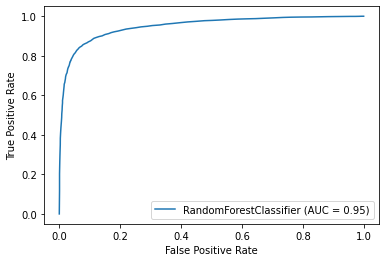

In [ ]:
# testing the RandomForest Classifier
test_forest_pred = forest.predict_proba(test_dataset)[:, 1]

calc_metrics(test_labels=test_labels, test_pred=test_forest_pred)
# the validation roc plot
plot_roc_curve(forest, test_dataset, test_labels)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Ran predictions. See metrics below:


Test Precision: 0.9206176400184631
Test Recall: 0.8484666347503662
Test F1-Score: 0.8830708203772367


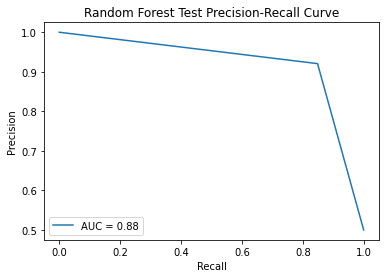

In [ ]:
precision_recall(forest, test_dataset, test_labels, model_type='Random Forest', save_file='pr_plot_test_randomForest.svg')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


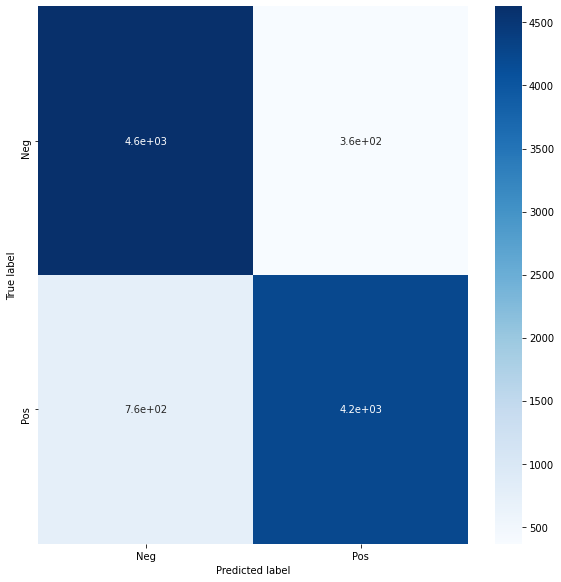

In [ ]:
create_confusion_matrix(forest, test_dataset, test_labels, save_file='confMat_randomForest_thresh97.svg')

## Testing CNN

312/312 [==============================] - 2s 8ms/step - loss: 0.6009 - auc_29: 0.9540 - binary_accuracy: 0.8949
Test Loss: 0.6009402275085449
Test AUC: 0.9539773464202881
Test Binary Acc: 0.8949003219604492


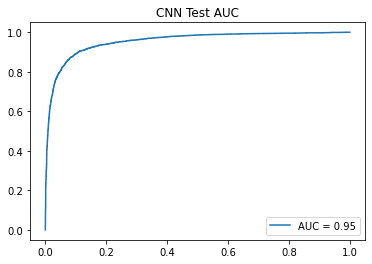

In [ ]:
# CNN (model 2) metrics
test_metrics2 = model2.evaluate(reshape_cnn_data(test_dataset), test_labels)

print(f"Test Loss: {test_metrics2[0]}")
print(f"Test AUC: {test_metrics2[1]}")
print(f"Test Binary Acc: {test_metrics2[2]}")

auc_plot = roc_plot(reshape_cnn_data(test_dataset), test_labels, model=model2, title='CNN Test AUC', file_path='auc_plot_test_cnn.jpg', format='jpg')

Ran predictions. See metrics below:


Test Precision: 0.965119481086731
Test Recall: 0.7043495774269104
Test F1-Score: 0.8143684906327522


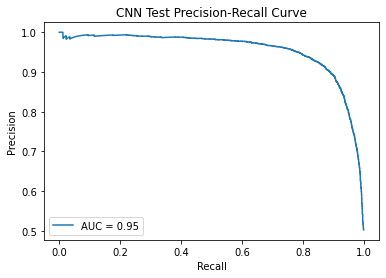

In [ ]:
precision_recall(model2, reshape_cnn_data(test_dataset), test_labels, model_type='CNN', save_file='pr_plot_test_cnn.svg')

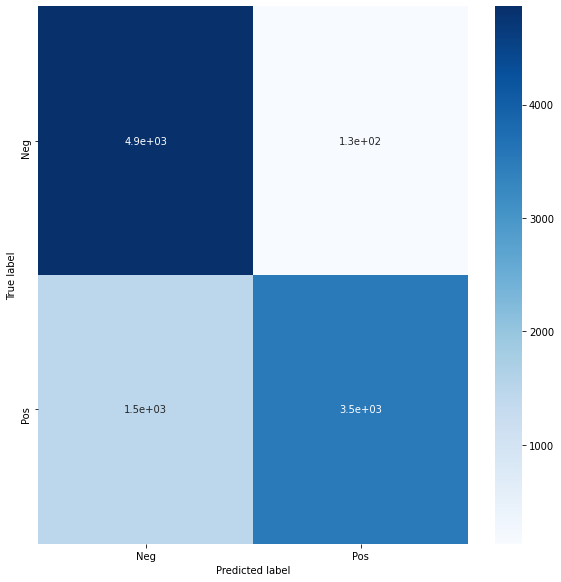

In [ ]:
create_confusion_matrix(model2, reshape_cnn_data(test_dataset), test_labels, save_file='confMat_cnn_thresh97.svg')

## Testing DNN

312/312 [==============================] - 1s 5ms/step - loss: 0.6508 - auc: 0.9199 - binary_accuracy: 0.8457
Test Loss: 0.6507691740989685
Test AUC: 0.9199422001838684
Test Binary Acc: 0.8457068204879761


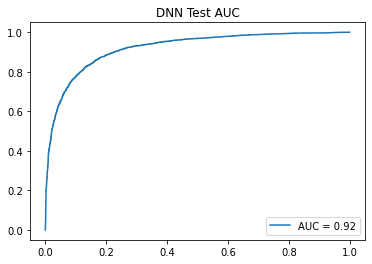

In [ ]:
test_metrics = model.evaluate(test_dataset, test_labels)

print(f"Test Loss: {test_metrics[0]}")
print(f"Test AUC: {test_metrics[1]}")
print(f"Test Binary Acc: {test_metrics[2]}")

auc_plot = roc_plot(test_dataset, test_labels, model=model, title='DNN Test AUC', file_path='auc_plot_test_dnn.jpg', format='jpg')

Ran predictions. See metrics below:


Test Precision: 0.9707854390144348
Test Recall: 0.4062938392162323
Test F1-Score: 0.572841592067472


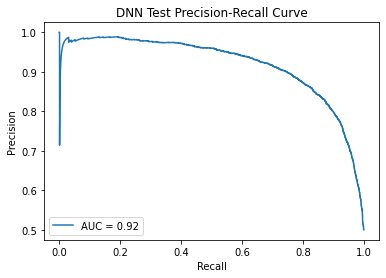

In [ ]:
precision_recall(model, test_dataset, test_labels, model_type='DNN', save_file='pr_plot_test_dnn.svg')

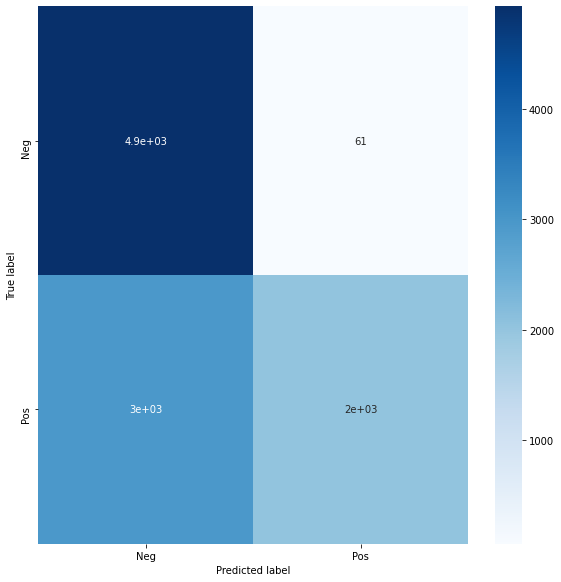

In [ ]:
create_confusion_matrix(model, test_dataset, test_labels, save_file='confMat_dnn_thresh97.svg')

## Testing Ensemble

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


Test Loss: 0.266810804605484
Test auc: 0.9588382840156555
Test acc: 0.8986073732376099


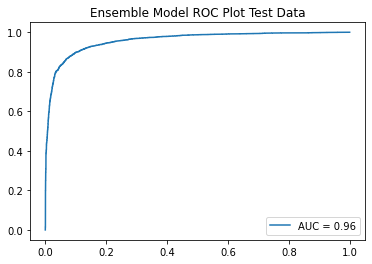

In [ ]:
# testing the ensemble
test_predict1 = forest.predict_proba(test_dataset)[:, 1].reshape(test_dataset.shape[0], 1)
test_predict2 = model2.predict(reshape_cnn_data(test_dataset), use_multiprocessing=True)
test_avg = np.mean([test_predict1, test_predict2], axis=0).T[0]

calc_metrics(test_labels=test_labels, test_pred=test_avg)

roc_plot(test_dataset, test_labels, pred=test_avg, title="Ensemble Model ROC Plot Test Data")

Ran predictions. See metrics below:


Test Precision: 0.9707854390144348
Test Recall: 0.4062938392162323
Test F1-Score: 0.572841592067472


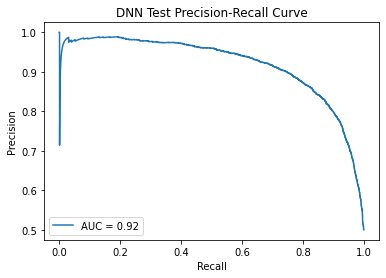

In [ ]:
precision_recall(model, test_dataset, test_labels, model_type='DNN')

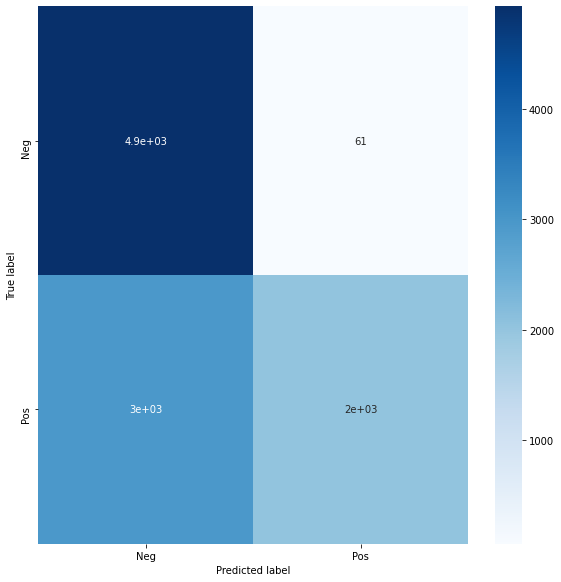

In [ ]:
create_confusion_matrix(model, test_dataset, test_labels)